In [39]:
#버전       V_0.03
#작성자     최연석
#분류       subQ3
#목표1      작성한 노트북을 캐글에 제출했다.
#목표2      처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 전처리, 학습, 최적화 진행 과정이 체계적
#목표3      피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 Private score 기준 110000 이하의 점수      
#수정사항   write 1st edit(2023.07.11)
#          change model - xgboost(2023.07.11)
#          find parameter - GridSearchCV(2023.07.12)


import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV

#FILE_PATH = "./" #local
FILE_PATH = "~/data/data/" #lms
FILE_NAME_TRAIN = "train.csv"
FILE_NAME_TEST = "test.csv"


#데이터 가져오기
def read_file(file_path, file_name_train, file_name_test):
    return pd.read_csv(file_path + file_name_train), pd.read_csv(file_path + file_name_test)


#데이터 저장
def save_file(file_path, file_name, df):
    print(df)
    df.to_csv(file_path+file_name, columns = ["id", "price"], index = False)


#분포 확인
def show_sns_distribution(df):
    f, ax = plt.subplots(figsize=(8, 6))
    sns.distplot(df['price'])
    plt.show()


#price log변환
def convert_log_data(df):
    df['price'] = np.log1p(df['price'])
    return df


#price exp변환(log1p 역함수)
def convert_exp_data(arr):
    arr = np.exp(arr) - 1
    return arr


#히트맵 출력
def show_sns_heatmap(df):
    sns.set(rc={'figure.figsize':(20,8)})
    sns.heatmap(data = df.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
    plt.show()


#temp / count 산점도 예측 결과 시각화
def show_plt_scatter(X_test, y_test, predictions):
    plt.scatter(X_test["grade"], y_test, label="true")
    plt.scatter(X_test["grade"], predictions, label="pred")
    plt.legend()
    plt.show()

In [40]:
try:
    #데이터 load       
    df_train, df_test = read_file(FILE_PATH, FILE_NAME_TRAIN, FILE_NAME_TEST)

    #데이터 컬럼 확인
    chk_colums = set(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                        'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                        'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
                        'sqft_living15', 'sqft_lot15'])

    if (not set(chk_colums).issubset(df_test.columns)):
            raise

    chk_colums.add('price')

    if (not set(chk_colums).issubset(df_train.columns)):
            raise

except:
    print("Error : failed to read data")

In [41]:
#데이터 정보 확인
print(df_train.info())
print(df_test.info())
print(df_train.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


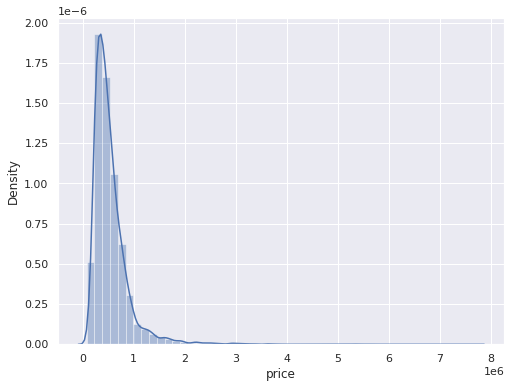

In [42]:
#정규화
#분포 확인
show_sns_distribution(df_train)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


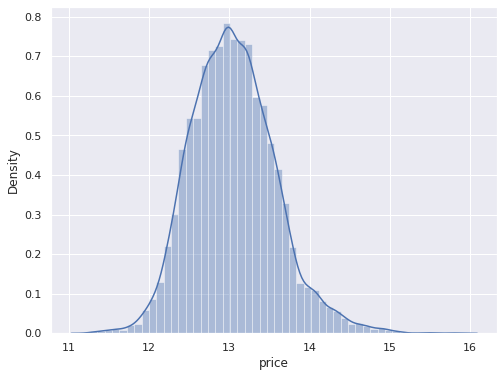

In [43]:
#price log변환
df_train = convert_log_data(df_train)
show_sns_distribution(df_train)

In [44]:
 #date 타입 변환 object -> datetime
df_train["date"] = pd.to_datetime(df_train["date"])
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             15035 non-null  int64         
 1   date           15035 non-null  datetime64[ns]
 2   price          15035 non-null  float64       
 3   bedrooms       15035 non-null  int64         
 4   bathrooms      15035 non-null  float64       
 5   sqft_living    15035 non-null  int64         
 6   sqft_lot       15035 non-null  int64         
 7   floors         15035 non-null  float64       
 8   waterfront     15035 non-null  int64         
 9   view           15035 non-null  int64         
 10  condition      15035 non-null  int64         
 11  grade          15035 non-null  int64         
 12  sqft_above     15035 non-null  int64         
 13  sqft_basement  15035 non-null  int64         
 14  yr_built       15035 non-null  int64         
 15  yr_renovated   1503

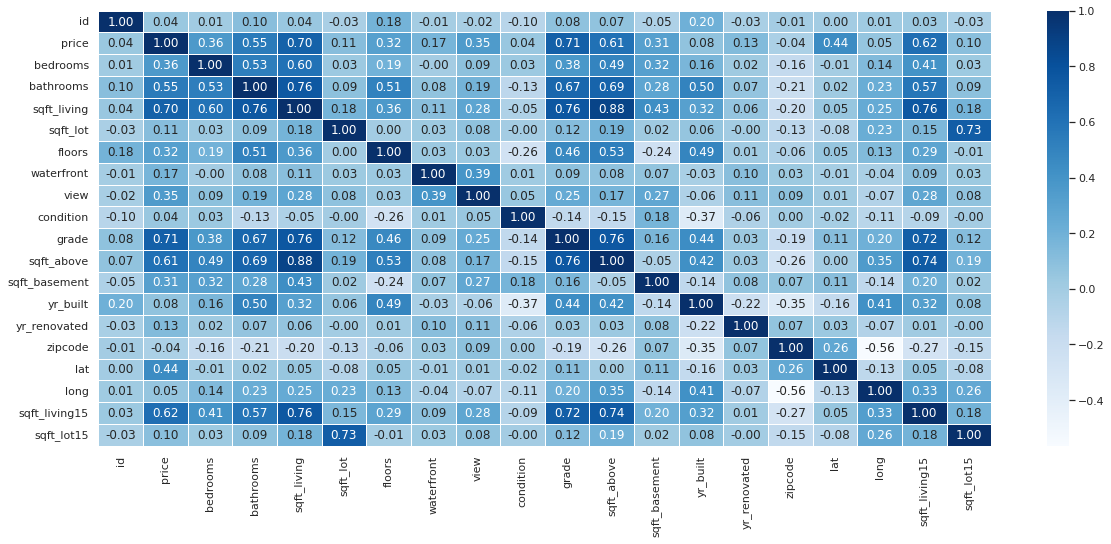

In [45]:
#히트맵 출력
show_sns_heatmap(df_train)

In [46]:
#불필요한 데이터 제거
del df_train["date"]
del df_train["id"]
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15035 non-null  float64
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [47]:
#train X, y 컬럼 선택 및 train 데이터 분리
print(df_train.columns)
df_X = df_train[['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above',
                'sqft_basement', 'lat', 'sqft_living15']]
df_y = df_train["price"]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=50)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [48]:
# xgb 부스팅 회귀 모델 생성
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)

In [ ]:
# GridSearchCV 최적 파라메터 찾기
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15]
}

grid_model = GridSearchCV(model, param_grid=param_grid, \
                            scoring='neg_mean_squared_error', \
                            cv=5, verbose=1, n_jobs=5)

grid_model.fit(X_train, y_train)

In [ ]:
print('best parameters : ' + str(grid_model.best_params_))

In [ ]:
print('best score : ' + str(grid_model.best_score_))

In [ ]:
params = grid_model.cv_results_['params']
print(params)

In [ ]:
score = grid_model.cv_results_['mean_test_score']
print(score)

In [ ]:
RMSE = np.sqrt(-1 * score)
print(RMSE)

In [ ]:
model = grid_model.best_estimator_ 

In [ ]:
model.fit(X_train,y_train)

In [ ]:
xgb.plot_importance(model)

In [ ]:
#학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산
predictions = model.predict(X_test)
print(predictions)

In [ ]:
#score
r_sq = model.score(X_train, y_train)
print(r_sq)
print(explained_variance_score(predictions,y_test))

In [ ]:
#test 전처리
df_test_X = df_test[['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above',
                'sqft_basement', 'lat', 'sqft_living15']]

In [ ]:
#test predictions
test_predictions = model.predict(df_test_X)
test_predictions = convert_exp_data(test_predictions)

In [ ]:
#test predictions 저장
df_test["price"] = test_predictions

In [ ]:
#파일 저장
try:
    save_file(FILE_PATH, "sunmission.csv", pd.DataFrame(df_test))
except:
    print("Error : failed to write data")
    return 1

print("program exit")
